# Display the development of the PDB over time

This is supplementary data for "The Life Cycle of Structural Biology Data", submitted to the Data Science Journal.

[PDBe Documentation](https://www.ebi.ac.uk/pdbe/api/doc/search.html).


## New Entries Released Each Year

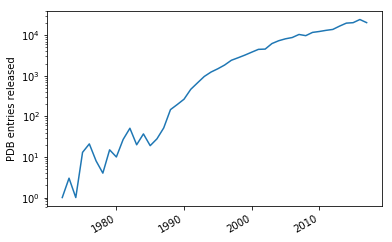

In [2]:
import pandas

PDBE_SOLR_URL = "http://www.ebi.ac.uk/pdbe/search/pdb"                 
# or https://www.ebi.ac.uk/pdbe/search/pdb/select?rows=0&q=status:REL&wt=json

from mysolr import Solr
solr = Solr(PDBE_SOLR_URL, version=4)

response = solr.search(**{
        "rows" : 0, # "fl" : "deposition_year", 
        "q" : 'status:REL',
        "facet" : "true", "facet.limit" : 1000000, "facet.mincount" : 1,
        "facet.field" : "deposition_year",
    }
)
from matplotlib import pyplot as plt

# skip current year, which is not yet complete
years = sorted( response.facets['facet_fields']['deposition_year'] )[0:-1]

fig = plt.figure()
plt.yscale('log')
plt.ylabel('PDB entries released')
plt.plot(years, [ response.facets['facet_fields']['deposition_year'][year] for year in years])
plt.xticks(['1980', '1990', '2000', '2010'])
fig.autofmt_xdate()
plt.savefig('../../images/PDB.eps', format='eps', dpi=1000)
plt.show()

## Complexes by year
If an entry referes to more than one macromolecule (i.e. is heteromeric) then the work is more challenging that research of a single protein.

There is another case. A project might target a homodimer, or more generally a homo-oligomer. For a homomeric protein structure, the PDB does not record the submitter's judgement of whether the contacts between the molecules are complexation of biological relevance, or merely crystal contacts. So we cannot distinguish targeted work on homo-complexes from other work on single species. We therefore report simply the proportion of projects that aim at one rather than many macromolecular species.

In [21]:
import collections

# returns all values, in increasing order of frequency
def get_values(field):
    response = solr.search(**{
        "rows" : 0, "fl" : "deposition_year", 
        "q" : 'status:REL',
        "facet" : "true", "facet.limit" : 10000000, "facet.mincount" : 1,
        "facet.field" : field,
        "group" : "true", "group.facet" : "true",
        "group.field" : "pdb_id",
    })
    d = response.facets['facet_fields'][field]
    return  collections.OrderedDict(reversed(list(d.items())))
values = get_values('assembly_form')
values

OrderedDict([('hetero', 31116), ('homo', 110874)])

In [45]:
from string import Template

def get_timeline(field):
    response = solr.search(**{
            "rows" : 0, "fl" : "deposition_year", 
            "q" : 'status:REL',
            'json.facet': Template("""{
                deposition_year:{
                    type:range,start:1971,end:2018,gap:1,field:deposition_year,limit:20,
                    facet:{
                        facet1:{
                            type:terms, field: $field,
                            facet:{
                                grouped_facet_count:\"unique(pdb_id)\"
                            }
                        },
                        grouped_depositionyear_count:\"unique(pdb_id)\"
                    }
                }
            }""").substitute(field=field)
        }
    )
    return response.raw_content['facets']['deposition_year']['buckets']

timeline = get_timeline('assembly_form')

# see an example of an annual report
timeline[-4]

{'val': 2014,
 'count': 19875,
 'grouped_depositionyear_count': 9365,
 'facet1': {'buckets': [{'val': 'hetero',
    'count': 12649,
    'grouped_facet_count': 2244},
   {'val': 'homo', 'count': 7121, 'grouped_facet_count': 7121}]}}

In [46]:
def get_df(synonyms, timeline):
    counts0 = {'unknown':0}
    for value in synonyms:
        counts0[ synonyms[value] ] = 0
    rows = []
    for bucket in timeline:
        year = int(bucket['val'])
        counts = dict(counts0)
        if bucket['count'] > 0:
            total = bucket['grouped_depositionyear_count']
            for bbucket in bucket['facet1']['buckets']:
                synonym = synonyms[ bbucket['val'] ]
                counts[ synonym ] = counts.get(synonym, 0)+bbucket['grouped_facet_count']
                total = total - bbucket['grouped_facet_count']
            counts['unknown'] = total
        rows.append([year]+[ counts[label] for label in counts0])  

    df = pandas.DataFrame(rows, columns=['year']+ list(counts0.keys()) )
    df = df[df.year>1977]
    return df

df = get_df( {'homo':'homomeric', 'hetero':'heteromeric'}, timeline)
df.head()

,year,unknown,homomeric,heteromeric
7,1978,0,4,0
8,1979,0,9,3
9,1980,0,7,1
10,1981,0,23,2
11,1982,0,33,9


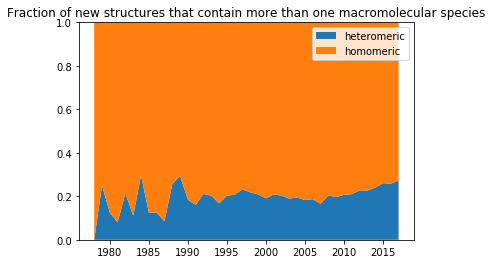

In [47]:

def plot_df(df, values):    
    df['total'] = pandas.Series([0]*len(df), index=df.index)
    for value in values:
        df['total'] = df['total'] + df[value]
    running_total = pandas.Series([0]*len(df), index=df.index)
    for value in values:
        series = df[value] / df['total']
        plt.fill_between(df.year, running_total, running_total+series, label=values[value])
        running_total = running_total + series
    # could plt.fill_between(df.year, running_total, [1]*len(df), color='black', label='unknown' )

    
plt.figure()
plot_df(df, {'heteromeric': 'heteromeric', 'homomeric': 'homomeric'})
plt.title('Fraction of new structures that contain more than one macromolecular species')
plt.ylim([0, 1])
#plt.savefig('../../images/complexes.eps', format='eps', dpi=1000)
plt.legend(fontsize=10)
plt.show()

# New entries, by superkingdom and cellular location

In [49]:

plt.figure(figsize=(200, 150))
plt.tight_layout()
plt.subplot(3,1,1)

timeline = get_timeline('assembly_form')
df = get_df( {'homo':'homomeric', 'hetero':'heteromeric'}, timeline)
plot_df(df, {'heteromeric': 'heteromeric', 'homomeric': 'homomeric'})
plt.title('Complexes', fontsize=200)
plt.legend(fontsize=100)
plt.yticks(fontsize=100)
plt.xticks([], [])

values = get_values('superkingdom')
timeline = get_timeline('superkingdom')
df = get_df({value:value for value in values}, timeline)

plt.subplot(3,1,2)
plt.title('Superkingdom', fontsize=200)
plot_df(df, {value: value for value in values})
plt.legend(fontsize=100)
plt.yticks(fontsize=100)
plt.xticks([], [])

values = get_values("biological_cell_component")

d = {value : ('membrane' if 'membrane' in value else 'other') for value in values}


timeline = get_timeline("biological_cell_component")
df = get_df(d, timeline)
plt.subplot(3,1,3)
plt.title('Membrane proteins', fontsize=200)
plot_df(df, {'membrane':'membrane', 'other':'other'})
plt.legend(fontsize=100)
plt.xticks(fontsize=100)
plt.yticks(fontsize=100)
plt.savefig('../../images/fig2.eps', format='eps', dpi=1000)
plt.show()

## Count entries by experiment type

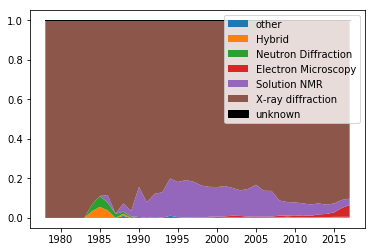

In [43]:
values = get_values("experimental_method")
d = {}
for value in values:
    d[value] = value if values[value]>120 else 'other'

timeline = get_timeline("experimental_method")
df = get_df(d, timeline)

plt.figure()
plot_df(df, {d[value]:d[value] for value in d})
plt.legend()
plt.show()